# Определение возраста покупателей

## Исследовательский анализ данных

# Описание проекта

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:

Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы; Контролировать добросовестность кассиров при продаже алкоголя. Постройте модель, которая по фотографии определит приблизительный возраст человека. В вашем распоряжении набор фотографий людей с указанием возраста.

# План работы над проектом

# Импорт библиотек

In [1]:
import numpy as mp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

from tensorflow.keras.layers import Conv2D, Flatten, Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50

# Исследовательский анализ данных

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')
labels

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17
...,...,...
7586,007608.jpg,14
7587,007609.jpg,37
7588,007610.jpg,28
7589,007611.jpg,20


В нашем файле 7591 строка с двумя колонками: в file_name записаны имена фотографий, а в real_age подлинный возраст людей изображенных на них

In [3]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


Выборка содержит 7591 запись. Не слишком много, попробую использовать ResNet. Пропусков не обнаружено.

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


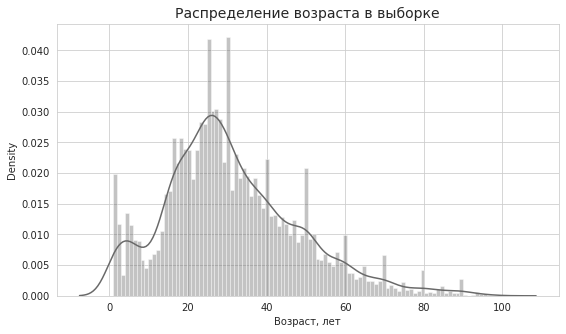

In [4]:
plt.figure(figsize=(9,5))
sns.distplot(labels['real_age'], color='dimgrey', bins=100)
plt.title('Распределение возраста в выборке', size=14)
plt.xlabel('Возраст, лет');

In [5]:
print(labels.describe())

          real_age
count  7591.000000
mean     31.201159
std      17.145060
min       1.000000
25%      20.000000
50%      29.000000
75%      41.000000
max     100.000000


В основном у нас люди в средней возрастной категории больше всего фотографий 30-ти и 20-ти летних людей, так же есть всплески на круглых датах, и на 18 и 16 годах, а так же относительно много фотографий годовалых детей. Изображений людей пенсионного возраста относительно немного.

In [6]:
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)

features, target = next(train_gen_flow)

Found 7591 validated image filenames.


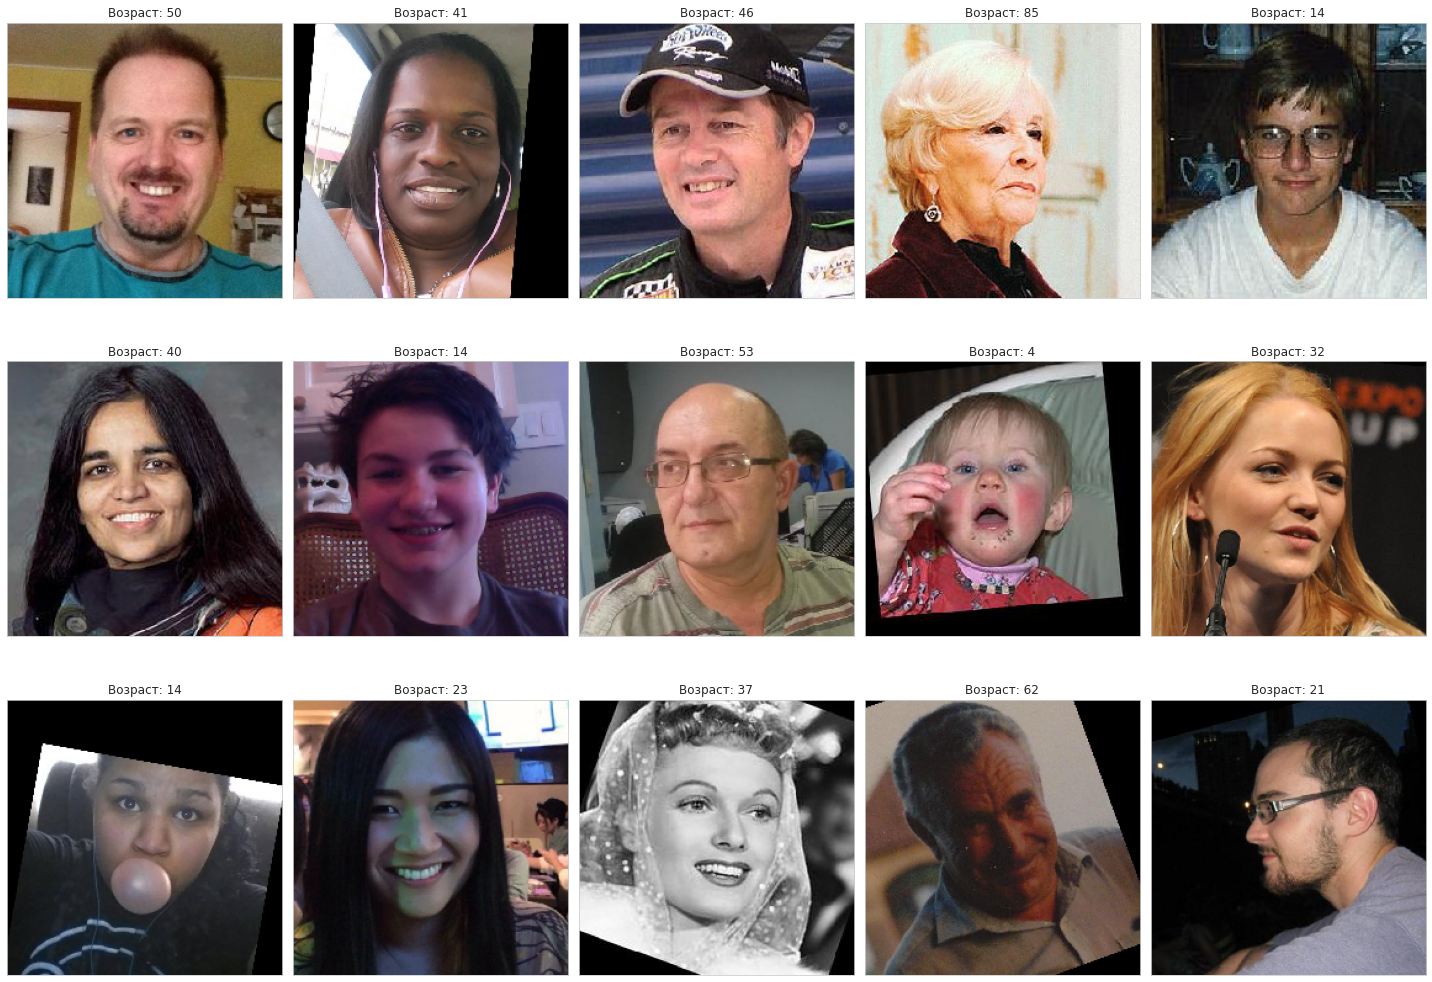

In [7]:
fig = plt.figure(figsize=(20,16))
for i in range(15):
    fig.add_subplot(3, 5, i+1)
    plt.imshow(features[i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()
    plt.title('Возраст: ' + str(target[i]))

В выборке есть повернутые и сдвинутые изображения, также фотографии сделанные в профиль и анфас, это позволит модели меньше переобучаться

<div style="font-size: 19px"> <b> Вывод по шагу 1</b>

Датасет обладает 7591 фотографиями. Небольшая выборка для оценки возраста.

Больше всего фотографий в диапазоне от 20 до 41 года. Также в выборке отмечены дети и старики.

С учетом вложенных фотографий модели будет непросто оценивать возраст. На фотографиях присутствуют объекты, которые закрывают лицо: рука, жвачка, очки, головной убор и т.д.

## Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python

from tensorflow.keras.layers import Conv2D, Flatten, Dense, AvgPool2D, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
import pandas as pd


import numpy as np


def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    train_datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255)
    train_datagen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='training',
        seed=12345
    )
    return train_datagen_flow

def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    test_datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255)
    test_datagen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='validation',
        seed=12345
    )
    return test_datagen_flow

def create_model(input_shape):
    optimizer = Adam(learning_rate=0.0001)
    backbone = ResNet50(input_shape=input_shape, weights='imagenet', include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))

    model.compile(loss='mse', optimizer=optimizer, metrics=['mae'])

    return model


def train_model(model, train_data, test_data, batch_size=None, epochs=10,
               steps_per_epoch=None, validation_steps=None):

    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)

        model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, 
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2, shuffle=True)

    return model

```

```

Train for 356 steps, validate for 119 steps
Epoch 1/10
2023-02-05 16:02:17.570853: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2023-02-05 16:02:19.706640: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
356/356 - 72s - loss: 200.9440 - mae: 10.3331 - val_loss: 549.1307 - val_mae: 18.3406
Epoch 2/10
356/356 - 42s - loss: 70.2676 - mae: 6.4321 - val_loss: 121.7449 - val_mae: 8.4130
Epoch 3/10
356/356 - 41s - loss: 39.3141 - mae: 4.8052 - val_loss: 142.7298 - val_mae: 9.3242
Epoch 4/10
356/356 - 42s - loss: 24.6282 - mae: 3.8776 - val_loss: 94.1912 - val_mae: 7.1684
Epoch 5/10
356/356 - 40s - loss: 18.4950 - mae: 3.3012 - val_loss: 83.8186 - val_mae: 6.7997
Epoch 6/10
356/356 - 40s - loss: 14.3669 - mae: 2.9008 - val_loss: 106.4540 - val_mae: 7.6439
Epoch 7/10
356/356 - 40s - loss: 12.3608 - mae: 2.7095 - val_loss: 66.6817 - val_mae: 6.1622
Epoch 8/10
Epoch 9/10
356/356 - 41s - loss: 10.7353 - mae: 2.5105 - val_loss: 71.6619 - val_mae: 6.3955
356/356 - 41s - loss: 9.9048 - mae: 2.3873 - val_loss: 66.7914 - val_mae: 6.0707
Epoch 10/10
356/356 - 44s - loss: 10.1935 - mae: 2.4067 - val_loss: 67.2628 - val_mae: 6.1790
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']


```

<div style="font-size: 19px"> <b> Вывод по шагу 2</b>

Модель в среднем ошибается на 6.18 лет.

Модель обучилась за 10 эпох, за основу была взята сеть ResNet50 с отключенными верхними слоями. Были инициализированы веса ImageNet. И добавлен верхний полносвязный слой с активатором ReLu. Функция потерь была задана MSE, в качестве оптимизатора был взят Adam c шагом спуска 0.0001.

Возможно стоило бы прогнать больше эпох и улучшить метрики. На протяжение 10 эпох функция потерь заметно уменьшалась.

## Анализ обученной модели

<div style="font-size: 19px"> <b> Итоговый вывод.</b>

Цель исследования выполнена: обученная модель демонстрирует показатель MAE = 6.18 без настройки параметров и аугментации данных.

Исходные данные содержали 7.5 тысяч записей, без пропусков и выбросов. Большинство людей на фотографиях запечетлено в возрастном диапазоне 20-41 года. В каждой 10-летней группе встречается повышенное количество круглых юбиляров (50-60-70 лет). Модель содержит архитектуру ResNet и предобученные на ImageNet сверточные слои. Исходя из мировой практики разделения покупателей на возрастные группы, ошибка в 6 лет максимум отнесет покупателей в соседнюю возрастную группу, что можно считать хорошим результатом для обученной модели.

Для справки.

В общемировой практике используется следующее сегментирование потребителей по возрасту:

0-14 лет: дети, покупательское поведение которых напрямую связано с покупательским поведением родителей.

На рынке детских товаров практикуется более подробное сегментирование по возрастному признаку этой группы: младенцы до года, дети от года до 7 лет, дети от 7-11 лет, дети от 11-14 лет

15-24 года: молодежь, которая принимает самостоятельные решения о покупке товаров. Иногда располагающие собственными денежными средствами. У представителей данной группы уровень достатка и принадлежность к определенному социальному классу еще не сформированы. Склонны проявлять нонконформистское поведение и часто становятся частью обособленных молодежных течений и групп.

25-44 года: экономически активное население, самостоятельно принимающее решение о покупке товаров. В большинстве своем семейные люди с уже сформированным уровнем достатка и социальным классом. На модель покупательского поведения начинают оказывать влияние дети.

45-64 года: экономически активное население, самостоятельно принимающее решение о покупке товаров. Их социальный уровень и доход полностью сформированы. Дети данной группы достаточно взрослые и не влияют на модель покупательского поведения. В поведении данной группы начинают проявляться личные интересы и цели, удовлетворения которых ни не смогли добиться в более раннем возрасте.

65 лет и старше: данная возрастная группа образует людей пенсионного возраста, не имеющих высокого уровня заработка.

## Чек-лист

- [x]  Jupyter Notebook открыт
- [ ]  Весь код выполняется без ошибок
- [ ]  Ячейки с кодом расположены в порядке исполнения
- [ ]  Исследовательский анализ данных выполнен
- [ ]  Результаты исследовательского анализа данных перенесены в финальную тетрадь
- [ ]  MAE модели не больше 8
- [ ]  Код обучения модели скопирован в финальную тетрадь
- [ ]  Результат вывода модели на экран перенесён в финальную тетрадь
- [ ]  По итогам обучения модели сделаны выводы